# Linear agent, 4 static obstacles, MIQP approach

In [1]:
clear
yalmip clear
close all
warning off

## The agent

First we load a demo agent:

In [2]:
N = 30;     % prediction horizon
Ts = 0.25;  % sampling time
agent = optiplan.LinearAgent.demo2D('PredictionHorizon', N, 'SamplingTime', Ts)

agent = 

  LinearAgent with properties:

                 A: [4430 optiplan.AgentSignal]
                 B: [4230 optiplan.AgentSignal]
                 f: [4130 optiplan.AgentSignal]
                 C: [2430 optiplan.AgentSignal]
                 D: [2230 optiplan.AgentSignal]
                 g: [2130 optiplan.AgentSignal]
                nx: 4
                nu: 2
                ny: 2
                 N: 30
                 X: [4131 optiplan.AgentSignal]
                 U: [2130 optiplan.AgentSignal]
                 Y: [2130 optiplan.AgentSignal]
              Size: [2130 optiplan.AgentSignal]
    ConstraintsFun: []
      ObjectiveFun: []


Tell the agent that the position reference should be treated as a time-varying parameter:

In [3]:
agent.Y.Reference = 'parameter';

Since we will be plotting the agent as a planar object, we set its width and height to one:

In [4]:
agent.Size.Value = [1; 1];

To choose between MIQP or Time-Varying Constraints approach, we need to set variable `MixedInteger` to true/false:

In [5]:
MixedInteger = true;

## The Obstacle

Then we create 4 static obstacles, set their visibility and size:

In [6]:
obstacles = optiplan.Obstacle(agent, 4);
for i = 1:length(obstacles)
    obstacles(i).Visible.Value = 1;   % all are visible to the agent
    obstacles(i).Size.Value = [3; 2]; % all have fixed size
end

And for each obstacle we set its position:

In [7]:
obstacles(1).Position.Value = [0; 10];
obstacles(2).Position.Value = [10; 0];
obstacles(3).Position.Value = [0; -10];
obstacles(4).Position.Value = [-10; 0];

and minimal separation gab between the agent and the obstacle:

In [8]:
minsep = agent.Size.Value;

## The Planner

Next, we create a planner which will be responsible for optimizing the control inputs for the agent:

In [9]:
planner = optiplan.Planner(agent, obstacles, 'MinSeparation', minsep,...
    'solver', 'gurobi', 'MixedInteger', MixedInteger)

planner = 

  Planner with properties:

      Parameters: [11 struct]
    MixedInteger: 1


## The Simulator

To make closed-loop simulation, we create Simulator:

In [10]:
psim = optiplan.Simulator(planner)

psim = 

  Simulator with properties:

       Results: [11 struct]
    Parameters: [11 struct]


Before starting the simulation, we need to define number of simulation steps, intial point and values for time-varying parameters:

In [11]:
Nsim = 350; % number of simulation steps
x0 = [0; 0; 0; 0]; % initial point
psim.Parameters.Agent.Y.Reference = psim.circularTrajectory(Nsim, 'Radius', 10, 'Loops', 2);

When done, we can run the simulation:

In [12]:
psim.run(x0, Nsim);

To plot the results, launch:

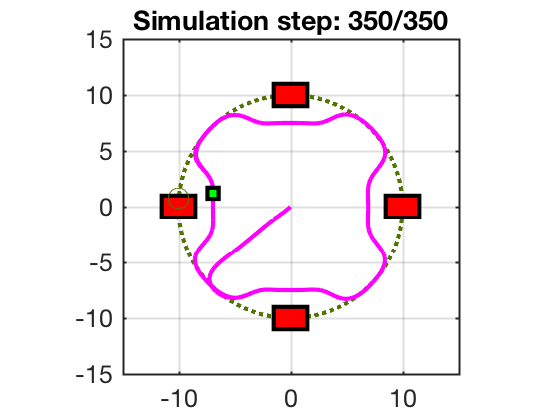

In [13]:
psim.plot('Axis', [-15 15 -15 15], 'Reference', true, 'Trail', true,...
        'Predictions', true, 'PredSteps', 10);

where '`Axis`' sets dimension of both axis, '`Reference`' enable/disable showing the reference, '`Predictions`' enable/disable showing predicted positions of the agent, '`PredSteps`' defines number of displayed predictions, '`Trail`' enable/disable showing realized trajectory of agent.

## Notes & hints

**Hint**: use the `Simulator/circularTrajectory` helper to automatically create a trajectory over `Nsim` steps which follows specified circular trajectory:

In [14]:
Nsim = 20;
r = optiplan.Simulator.circularTrajectory(Nsim, 'Radius', 5, 'Loops', 1)

r =

  Columns 1 through 7

   -5.0000   -4.7553   -4.0451   -2.9389   -1.5451    0.0000    1.5451
   -0.0000   -1.5451   -2.9389   -4.0451   -4.7553   -5.0000   -4.7553

  Columns 8 through 14

    2.9389    4.0451    4.7553    5.0000    4.7553    4.0451    2.9389
   -4.0451   -2.9389   -1.5451         0    1.5451    2.9389    4.0451

  Columns 15 through 21

    1.5451    0.0000   -1.5451   -2.9389   -4.0451   -4.7553   -5.0000
    4.7553    5.0000    4.7553    4.0451    2.9389    1.5451    0.0000
